In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.coordinates import SkyCoord
import regions
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x2b45c930fb20>

In [2]:
basepath = '/orange/adamginsburg/orion/Orion_ALMA_2016.1.00165.S/'

In [3]:
scrIreg = regions.EllipseSkyRegion(SkyCoord('5:35:14.517 -5:22:30.620', unit=(u.hour, u.deg)),
                                   height=0.18*u.arcsec, width=0.5*u.arcsec, angle=50.5*u.deg)

In [4]:
cube = (SpectralCube
        .read('/orange/adamginsburg/orion/2016.1.00165.S/external/full_OrionSourceI_B6_spw1_lines_cutout.fits', use_dask=True)
        .subcube_from_regions([scrIreg])
       )
cube

DaskVaryingResolutionSpectralCube with shape=(1920, 101, 86) and unit=Jy / beam and chunk size (320, 101, 86):
 n_x:     86  type_x: RA---SIN  unit_x: deg    range:    83.810440 deg:   83.810535 deg
 n_y:    101  type_y: DEC--SIN  unit_y: deg    range:    -5.375228 deg:   -5.375117 deg
 n_s:   1920  type_s: FREQ      unit_s: Hz     range: 231834857246.900 Hz:233708832546.243 Hz

In [5]:
cube_sclip = cube.sigma_clip_spectrally(3)
mad_std_spectrum_sclip = cube_sclip.mad_std(axis=(1, 2))

Text(0, 0.5, ' Noise standard deviation $\\sigma$ (K)')

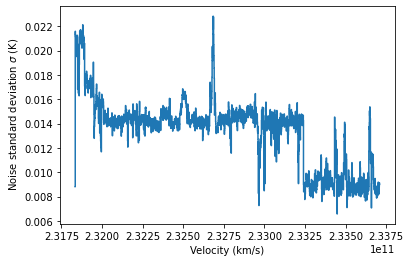

In [6]:
pl.plot(mad_std_spectrum_sclip.spectral_axis.value, mad_std_spectrum_sclip.value, 
         drawstyle='steps-mid')
pl.xlabel('Velocity (km/s)')
pl.ylabel(r' Noise standard deviation $\sigma$ (K)')

In [7]:
mask = ((mad_std_spectrum_sclip.value > 0.013) &
        (mad_std_spectrum_sclip.value < 0.0145))[:,None,None]

In [8]:
cube_sclip_cut = cube_sclip.with_mask(mask)
mad_std_spectrum_sclip_cut = cube_sclip_cut.mad_std(axis=(1, 2))

Text(0, 0.5, ' Noise standard deviation $\\sigma$ (K)')

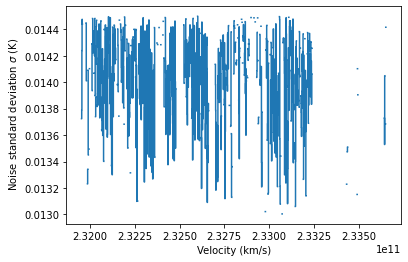

In [9]:
pl.plot(mad_std_spectrum_sclip_cut.spectral_axis.value, mad_std_spectrum_sclip_cut.value, 
      drawstyle='steps-mid')
pl.xlabel('Velocity (km/s)')
pl.ylabel(r' Noise standard deviation $\sigma$ (K)')

In [10]:
# Calculate and apply plain mask
mad_std_map_sclip = cube_sclip_cut.mad_std(axis=0) # Calculate sigma along the spectral dimension

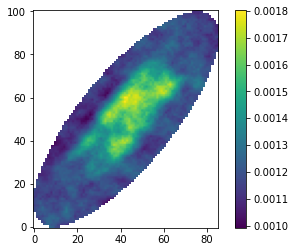

In [11]:
mad_std_map_sclip = cube_sclip_cut.mad_std(axis=0) # Calculate sigma along the spectral dimension
mad_std_map_sclip.quicklook(use_aplpy=False)
pl.colorbar()

In [12]:
restfreq = 232.50997700*u.GHz

In [13]:
vcube = (cube
         .with_spectral_unit(u.km/u.s, rest_value=restfreq, velocity_convention='radio')
         .spectral_slab(-20*u.km/u.s, 30*u.km/u.s)
        ) - cube.median(axis=0)

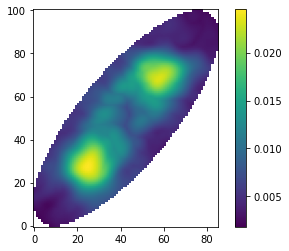

In [14]:
peak = vcube.max(axis=0)
peak.quicklook(use_aplpy=False)
pl.colorbar()

INFO: Auto-setting vmin to -2.678e-03 [aplpy.core]
INFO: Auto-setting vmax to  2.580e-02 [aplpy.core]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

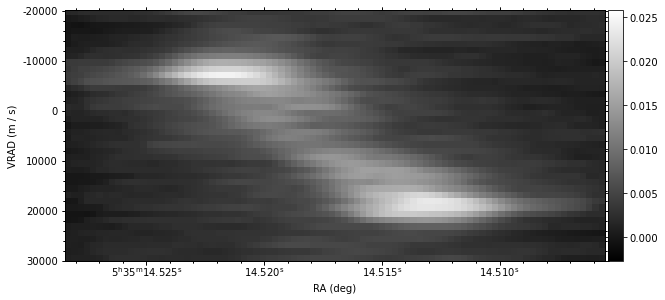

In [15]:
vcube.max(axis=1).quicklook()
pl.colorbar()

mask = vcube > 5*u.mJy/u.beam

In [ ]:
mask = vcube >= 3 * mad_std_map_sclip # Get plain 3sigma mask
masked_slab = vcube.with_mask(plain_mask) # Mask the template molecule cube

In [ ]:
pl.imshow(mask.include().sum(axis=0))

In [ ]:
pl.imshow(mask.include().sum(axis=1))

In [ ]:
import scipy.ndimage as nd

In [ ]:
low_snr_mask = (masked_slab > 3 * mad_std_map_sclip).include()

In [ ]:
structure = np.ones((3, 3, 3), dtype=bool)
signal_mask = nd.binary_dilation(low_snr_mask, structure=structure, iterations=1)

In [ ]:
pl.figure(figsize=(10,4))
pl.subplot(1,3,1).imshow(signal_mask.sum(axis=0))
pl.subplot(1,3,2).imshow(signal_mask.sum(axis=1))
pl.subplot(1,3,3).imshow(signal_mask.sum(axis=2))